<a href="https://colab.research.google.com/github/isabellacadisco/rps-image-classification/blob/master/RPS_mock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0) Setup

In [1]:
a = 2

In [2]:
print(a)

2


In [3]:
b = 7
print(a+b)

9


In [2]:
import sys
print(sys.executable)


c:\Users\dgmar\Isa\rps-image-classification\.venv\Scripts\python.exe


In [3]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # This shows if CUDA (GPU) is usable

2.5.1+cu121
True


In [6]:
print("PyTorch:", torch.__version__)

PyTorch: 2.5.1+cu121


In [32]:
# Colab: GPU check
import torch, sys, os, shutil, zipfile, random, math, time
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

#!pip -q install kaggle --upgrade


PyTorch: 2.5.1+cu121
CUDA available: True


1) Download data

In [17]:
import matplotlib.pyplot as plt

In [10]:
import os, pathlib, json, subprocess
#from google.colab import files

In [ ]:
#DATA_DIR = pathlib.Path("/content/data_rps")
#RAW_DIR = DATA_DIR / "raw" # forse potrebbero servirci dopo quando diamo una struttura
#PROC_DIR = DATA_DIR / "processed" # forse potrebbero servirci dopo quando diamo una struttura
#PROC_DIR.mkdir(parents=True, exist_ok=True)

In [12]:
DATA_DIR = pathlib.Path("/data")

In [ ]:
if pathlib.Path("/root/.kaggle/kaggle.json").exists():
  print("ok")
else:
  # Upload your Kaggle API key (kaggle.json)
  # You can get it from your Kaggle account -> Settings -> Create New API Token
  #files.upload()  # Choose kaggle.json

  # Move it to the correct location
  !mkdir -p ~/.kaggle
  !mv kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

NameError: name 'files' is not defined

In [13]:
import os
import shutil
from pathlib import Path

kaggle_path = Path.home() / ".kaggle" / "kaggle.json"

if kaggle_path.exists():
    print("✅ kaggle.json already exists.")
else:
    print("❌ kaggle.json not found. Please make sure it's in the current directory.")

    # Check if kaggle.json is in current working directory
    local_kaggle_json = Path("kaggle.json")
    if local_kaggle_json.exists():
        # Create ~/.kaggle directory if it doesn't exist
        kaggle_dir = Path.home() / ".kaggle"
        kaggle_dir.mkdir(parents=True, exist_ok=True)

        # Move the file
        shutil.move(str(local_kaggle_json), str(kaggle_path))

        # Set permissions (600 = owner read/write only)
        os.chmod(kaggle_path, 0o600)

        print("✅ kaggle.json moved to ~/.kaggle and permissions set.")
    else:
        print("⚠️ kaggle.json not found in the current directory. Please provide it.")


❌ kaggle.json not found. Please make sure it's in the current directory.
✅ kaggle.json moved to ~/.kaggle and permissions set.


In [14]:
# download dataset
!kaggle datasets download -d drgfreeman/rockpaperscissors

Dataset URL: https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors
License(s): CC-BY-SA-4.0




  0%|          | 0.00/306M [00:00<?, ?B/s]
 26%|██▌       | 80.0M/306M [00:00<00:00, 836MB/s]
 52%|█████▏    | 160M/306M [00:00<00:00, 812MB/s] 
 78%|███████▊  | 239M/306M [00:00<00:00, 816MB/s]
100%|██████████| 306M/306M [00:00<00:00, 809MB/s]


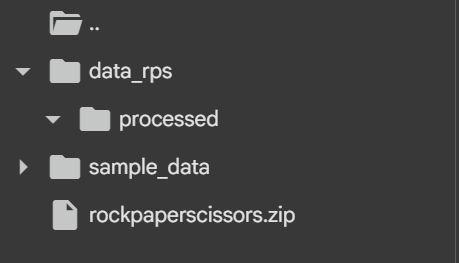

In [15]:
# Unzip it in data_rps
!unzip -q rockpaperscissors.zip -d data #data_rps

"unzip" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


In [16]:
import zipfile
from pathlib import Path

zip_path = Path("rockpaperscissors.zip")
extract_path = Path("data") / "data_rps"

# Crea la cartella di destinazione se non esiste
extract_path.mkdir(parents=True, exist_ok=True)

# Estrae il contenuto
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"✅ File estratti in: {extract_path.resolve()}")


✅ File estratti in: C:\Users\dgmar\Isa\rps-image-classification\data\data_rps


In [18]:
# inspect structure
import os
from PIL import Image
data_dir = r"data\data_rps/rps-cv-images"  # main folder containing rock/paper/scissors
classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
print(f"Classes found: {classes}\n")

Classes found: ['paper', 'rock', 'scissors']



In [19]:
# Count total images per class
for cls in classes:
    count = len(os.listdir(os.path.join(data_dir, cls)))
    print(f"{cls}: {count} images")

# Count total images
total = sum(len(os.listdir(os.path.join(data_dir, c))) for c in classes)
print(f"\nTotal images: {total}")

paper: 712 images
rock: 726 images
scissors: 750 images

Total images: 2188


In [20]:
# Check image dimensions
sample_path = os.path.join(data_dir, classes[0], os.listdir(os.path.join(data_dir, classes[0]))[0])
img = Image.open(sample_path)
print(f"\nSample image size: {img.size} (width, height)")
print(f"Mode (color channels): {img.mode}")


Sample image size: (300, 200) (width, height)
Mode (color channels): RGB


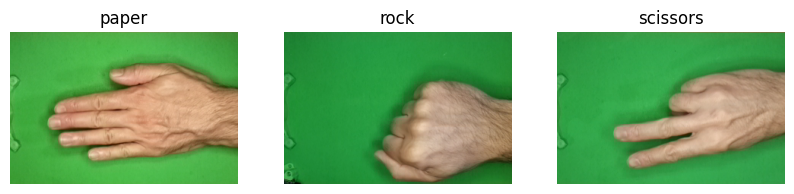

In [21]:
# Visualize examples

fig, axs = plt.subplots(1, 3, figsize=(10, 4))
for i, cls in enumerate(classes):
    img_path = os.path.join(data_dir, cls, os.listdir(os.path.join(data_dir, cls))[0])
    axs[i].imshow(Image.open(img_path))
    axs[i].set_title(cls)
    axs[i].axis("off")

plt.show()

In [7]:
import os

# Percorsi delle due directory
dir1 = r"data\data_rps"
dir2 = r"data\data_rps/rps-cv-images"

# Classi da confrontare
classes = ["paper", "rock", "scissors"]

for cls in classes:
    path1 = os.path.join(dir1, cls)
    path2 = os.path.join(dir2, cls)

    # Controlla che entrambe le cartelle esistano
    if not os.path.exists(path1):
        print(f"❌ La cartella {path1} non esiste.")
        continue
    if not os.path.exists(path2):
        print(f"❌ La cartella {path2} non esiste.")
        continue

    # Lista dei file
    files1 = sorted(os.listdir(path1))
    files2 = sorted(os.listdir(path2))

    # Confronto dei file
    diff1 = set(files1) - set(files2)
    diff2 = set(files2) - set(files1)

    if not diff1 and not diff2:
        print(f"✅ Le cartelle '{cls}' sono uguali in entrambe le directory.")
    else:
        print(f"⚠️ Differenze trovate nella cartella '{cls}':")
        if diff1:
            print(f"  - Presenti solo in {dir1}/{cls}: {len(diff1)} file")
        if diff2:
            print(f"  - Presenti solo in {dir2}/{cls}: {len(diff2)} file")


✅ Le cartelle 'paper' sono uguali in entrambe le directory.
✅ Le cartelle 'rock' sono uguali in entrambe le directory.
✅ Le cartelle 'scissors' sono uguali in entrambe le directory.


In [8]:
#RAW_DIR = pathlib.Path("/content/raw")
RAW_DIR = pathlib.Path(r"data\raw")

NameError: name 'pathlib' is not defined

In [37]:
import shutil

source_dir = r"data\data_rps\rps-cv-images"
destination_dir = RAW_DIR # Using the RAW_DIR variable defined earlier

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Copy the contents of the source directory to the destination directory
for item in os.listdir(source_dir):
    s = os.path.join(source_dir, item)
    d = os.path.join(destination_dir, item)
    if os.path.isdir(s):
        shutil.copytree(s, d, dirs_exist_ok=True)
    else:
        shutil.copy2(s, d)

print(f"Contents of '{source_dir}' copied to '{destination_dir}'.")

Contents of 'data\data_rps\rps-cv-images' copied to 'data\raw'.


2) Preprocess data

In [44]:
PROC_DIR = pathlib.Path(r"\data\processed") # questa mi serve come riferimento sempre

In [39]:
# train, val, test split

In [54]:
from pathlib import Path

ROOT = Path.cwd()  # oppure: Path(__file__).resolve().parent se è uno script
PROC_DIR = ROOT / "data" / "processed"
RAW_DIR  = ROOT / "data" / "raw"


In [55]:
import shutil

for d in [PROC_DIR/"train", PROC_DIR/"val", PROC_DIR/"test"]:
    if d.exists():
        shutil.rmtree(d)
    d.mkdir(parents=True, exist_ok=True)


In [56]:
print("PROC_DIR ->", PROC_DIR.resolve())
print("train:", len(list((PROC_DIR/"train").rglob("*"))),
      "val:",   len(list((PROC_DIR/"val").rglob("*"))),
      "test:",  len(list((PROC_DIR/"test").rglob("*"))))


PROC_DIR -> C:\Users\dgmar\Isa\rps-image-classification\data\processed
train: 0 val: 0 test: 0


In [45]:
import pathlib

SPLIT_DIR = pathlib.Path(PROC_DIR)
train_dir = pathlib.Path(SPLIT_DIR) / "train"
val_dir   = pathlib.Path(SPLIT_DIR) / "val"
test_dir  = pathlib.Path(SPLIT_DIR) / "test"

In [47]:
SPLIT_DIR, train_dir, val_dir, test_dir 

(WindowsPath('/data/processed'),
 WindowsPath('/data/processed/train'),
 WindowsPath('/data/processed/val'),
 WindowsPath('/data/processed/test'))

In [51]:
#Elimina le cartelle train_dir, val_dir e test_dir se esistono.
#Le ricrea vuote e pronte per essere riempite
for d in [train_dir, val_dir, test_dir]:
    if d.exists(): shutil.rmtree(d)
    d.mkdir(parents=True, exist_ok=True)

In [57]:
## TRAIN VAL TEST SPLIT - per ora uso sklearn, eventualmente cambio
from sklearn.model_selection import train_test_split
from pathlib import Path

def copy_split(src_root: Path, val_ratio=0.15, test_ratio=0.15):

    # Legge i nomi delle classi come sottocartelle in src_root e le crea in train/, val/, test
    classes = [d.name for d in src_root.iterdir() if d.is_dir()]
    classes = sorted(classes)
    for cls in classes:
        (train_dir/cls).mkdir(parents=True, exist_ok=True)
        (val_dir/cls).mkdir(parents=True, exist_ok=True)
        (test_dir/cls).mkdir(parents=True, exist_ok=True)

        imgs = sorted([p for p in (src_root/cls).glob("*") if p.suffix.lower() in {".png",".jpg",".jpeg"}])

        train_imgs, temp = train_test_split(imgs, test_size=(val_ratio+test_ratio), random_state=SEED, stratify=None)
        rel = test_ratio / (val_ratio+test_ratio)
        val_imgs, test_imgs = train_test_split(temp, test_size=rel, random_state=SEED, stratify=None)

        for p in train_imgs: shutil.copy(p, train_dir/cls/p.name)
        for p in val_imgs:   shutil.copy(p, val_dir/cls/p.name)
        for p in test_imgs:  shutil.copy(p, test_dir/cls/p.name)

In [58]:
copy_split(RAW_DIR)

In [59]:
from pathlib import Path

for split in ["train", "val", "test"]:
    d = PROC_DIR / split
    n = sum(1 for _ in d.rglob("*.png")) + sum(1 for _ in d.rglob("*.jpg")) + sum(1 for _ in d.rglob("*.jpeg"))
    print(split, "->", d.resolve(), "files:", n)


train -> C:\Users\dgmar\Isa\rps-image-classification\data\processed\train files: 0
val -> C:\Users\dgmar\Isa\rps-image-classification\data\processed\val files: 0
test -> C:\Users\dgmar\Isa\rps-image-classification\data\processed\test files: 0


In [60]:
RAW_DIR

WindowsPath('c:/Users/dgmar/Isa/rps-image-classification/data/raw')

In [12]:
ROOT = Path.cwd()
SRC_ROOT = ROOT / "data" / "data_rps"   # <-- qui ci sono le immagini orginali
RAW_DIR  = ROOT / "data" / "raw"
PROC_DIR = ROOT / "data" / "processed"
SEED = 42

train_dir = PROC_DIR / "train"
val_dir   = PROC_DIR / "val"
test_dir  = PROC_DIR / "test"

In [61]:
from pathlib import Path
import shutil, random

ROOT = Path.cwd()
SRC_ROOT = ROOT / "data" / "data_rps"   # <-- qui ci sono le immagini orginali
RAW_DIR  = ROOT / "data" / "raw"
PROC_DIR = ROOT / "data" / "processed"
SEED = 42
random.seed(SEED)

# 1) Prepara raw/ copiando le classi
for cls in ["paper", "rock", "scissors"]:
    src_cls = SRC_ROOT / cls
    dst_cls = RAW_DIR / cls
    dst_cls.mkdir(parents=True, exist_ok=True)
    # copia solo file immagine (non sovrascrive se già presenti con stesso nome)
    for p in src_cls.rglob("*"):
        if p.is_file() and p.suffix.lower() in {".png",".jpg",".jpeg"}:
            shutil.copy(p, dst_cls / p.name)

# 2) Pulisci processed/ e crea split
train_dir = PROC_DIR / "train"
val_dir   = PROC_DIR / "val"
test_dir  = PROC_DIR / "test"
for d in [train_dir, val_dir, test_dir]:
    if d.exists(): shutil.rmtree(d)
    d.mkdir(parents=True, exist_ok=True)

from sklearn.model_selection import train_test_split

def copy_split(src_root: Path, val_ratio=0.15, test_ratio=0.15):
    classes = sorted([d.name for d in src_root.iterdir() if d.is_dir()])
    for cls in classes:
        (train_dir/cls).mkdir(parents=True, exist_ok=True)
        (val_dir/cls).mkdir(parents=True, exist_ok=True)
        (test_dir/cls).mkdir(parents=True, exist_ok=True)

        # usa ** per scendere nelle sottocartelle
        imgs = sorted([p for p in (src_root/cls).glob("**/*")
                       if p.is_file() and p.suffix.lower() in {".png",".jpg",".jpeg"}])

        if not imgs:
            print(f"[WARN] Nessuna immagine trovata in {src_root/cls}")
            continue

        temp_train, temp = train_test_split(imgs, test_size=(val_ratio+test_ratio),
                                            random_state=SEED, shuffle=True)
        rel = test_ratio/(val_ratio+test_ratio)
        val_imgs, test_imgs = train_test_split(temp, test_size=rel,
                                               random_state=SEED, shuffle=True)

        for p in temp_train: shutil.copy(p, train_dir/cls/p.name)
        for p in val_imgs:   shutil.copy(p,   val_dir/cls/p.name)
        for p in test_imgs:  shutil.copy(p,  test_dir/cls/p.name)

copy_split(RAW_DIR)

# 3) Sanity check
for split in ["train","val","test"]:
    d = PROC_DIR/split
    n = sum(1 for _ in d.rglob("*.png")) + sum(1 for _ in d.rglob("*.jpg")) + sum(1 for _ in d.rglob("*.jpeg"))
    print(split, "->", d.resolve(), "files:", n)


train -> C:\Users\dgmar\Isa\rps-image-classification\data\processed\train files: 1531
val -> C:\Users\dgmar\Isa\rps-image-classification\data\processed\val files: 328
test -> C:\Users\dgmar\Isa\rps-image-classification\data\processed\test files: 329


quick exploration

In [13]:
# Check distribution of classes in paper, rock, scissors
from pathlib import Path

IMG_EXTS = {".png", ".jpg", ".jpeg"}

def _count_in_dir(d: Path):
    if not d.exists():
        return 0
    return sum(1 for p in d.glob("*") if p.suffix.lower() in IMG_EXTS)

def show_split_stats(train_dir: Path, val_dir: Path, test_dir: Path):
    classes = sorted({p.name for p in train_dir.iterdir() if p.is_dir()}
                     | {p.name for p in val_dir.iterdir() if p.is_dir()}
                     | {p.name for p in test_dir.iterdir() if p.is_dir()})

    print(f"Classi trovate: {classes}\n")
    header = f"{'classe':<15}{'train':>8}{'val':>8}{'test':>8}{'tot':>8}   {'%train':>7}{'%val':>7}{'%test':>7}"
    print(header)
    print("-"*len(header))

    totals = {"train":0, "val":0, "test":0, "all":0}

    for cls in classes:
        t = _count_in_dir(train_dir/cls)
        v = _count_in_dir(val_dir/cls)
        te = _count_in_dir(test_dir/cls)
        tot = t+v+te
        totals["train"] += t
        totals["val"]   += v
        totals["test"]  += te
        totals["all"]   += tot

        p_train = (t/tot*100) if tot else 0.0
        p_val   = (v/tot*100) if tot else 0.0
        p_test  = (te/tot*100) if tot else 0.0

        print(f"{cls:<15}{t:>8}{v:>8}{te:>8}{tot:>8}   {p_train:6.1f}%{p_val:6.1f}%{p_test:6.1f}%")

    print("-"*len(header))
    P = lambda n: (n/totals["all"]*100) if totals["all"] else 0.0
    print(f"{'TOTALE':<15}{totals['train']:>8}{totals['val']:>8}{totals['test']:>8}{totals['all']:>8}   "
          f"{P(totals['train']):6.1f}%{P(totals['val']):6.1f}%{P(totals['test']):6.1f}%")

# Esegui dopo copy_split(...)
show_split_stats(train_dir, val_dir, test_dir)


Classi trovate: ['paper', 'rock', 'scissors']

classe            train     val    test     tot    %train   %val  %test
-----------------------------------------------------------------------
paper               498     107     107     712     69.9%  15.0%  15.0%
rock                508     109     109     726     70.0%  15.0%  15.0%
scissors            525     112     113     750     70.0%  14.9%  15.1%
-----------------------------------------------------------------------
TOTALE             1531     328     329    2188     70.0%  15.0%  15.0%


In [63]:
import glob
from collections import Counter

def count_images(root):
    counts = {}
    for cls_dir in sorted(glob.glob(f"{root}/*")):
        if os.path.isdir(cls_dir):
            cls = os.path.basename(cls_dir)
            n = len(glob.glob(f"{cls_dir}/*"))
            counts[cls] = n
    return counts

train_counts = count_images(train_dir)
val_counts   = count_images(val_dir)
test_counts  = count_images(test_dir)

print("Train counts:", train_counts)
print("Val counts:  ", val_counts)
print("Test counts: ", test_counts)
print("Total images:", sum(train_counts.values()) + sum(val_counts.values()) + sum(test_counts.values()))


Train counts: {'paper': 498, 'rock': 508, 'scissors': 525}
Val counts:   {'paper': 107, 'rock': 109, 'scissors': 112}
Test counts:  {'paper': 107, 'rock': 109, 'scissors': 113}
Total images: 2188


In [64]:
#from google.colab import drive
#drive.mount('/content/drive')


In [ ]:
# EXECUTE ONLY FIRST TIME, THEN TAKE DATA FROM DRIVE
# copy to drive train, val, test
#!cp -r /content/processed /content/drive/MyDrive/RPS-data/processed
# copy to drive raw data
#!cp -r /content/raw /content/drive/MyDrive/RPS-data/raw

In [ ]:
# copy processed data from drive to colab
#!cp -r /content/drive/MyDrive/RPS-data/processed /content/processed

In [14]:
classes = ['rock', 'scissors', 'paper']
from PIL import Image

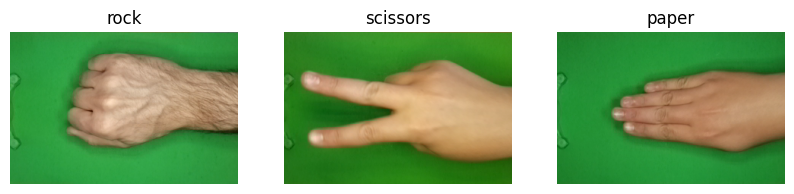

In [18]:
# use it as test for processed data locally
# #Visualize examples from drive
#processed_dir_from_drive = #"/content/drive/MyDrive/RPS-data/processed/val"

processed_dir_from_drive = r"data\processed\val"

fig, axs = plt.subplots(1, 3, figsize=(10, 4))
for i, cls in enumerate(classes):
    img_path = os.path.join(processed_dir_from_drive, cls, os.listdir(os.path.join(processed_dir_from_drive, cls))[0])
    axs[i].imshow(Image.open(img_path))
    axs[i].set_title(cls)
    axs[i].axis("off")

plt.show()

3) Transform, Datasets, Dataloaders

In [19]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [20]:
IMG_SIZE = 64 #128
BATCH_SIZE = 64

In [21]:
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # Augment (optional but helpful)
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])  # scale to [-1,1]
])

In [22]:
test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

In [23]:
train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds   = datasets.ImageFolder(val_dir,   transform=test_tfms)
test_ds  = datasets.ImageFolder(test_dir,  transform=test_tfms)

In [24]:
train_ds

Dataset ImageFolder
    Number of datapoints: 1531
    Root location: c:\Users\dgmar\Isa\rps-image-classification\data\processed\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=None, hue=None)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [74]:
val_ds

Dataset ImageFolder
    Number of datapoints: 328
    Root location: c:\Users\dgmar\Isa\rps-image-classification\data\processed\val
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [75]:
test_ds

Dataset ImageFolder
    Number of datapoints: 329
    Root location: c:\Users\dgmar\Isa\rps-image-classification\data\processed\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [25]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [26]:
CLASS_NAMES = train_ds.classes

In [27]:
NUM_CLASSES = len(CLASS_NAMES)
print("Classes:", CLASS_NAMES)

Classes: ['paper', 'rock', 'scissors']


4) CNN architectures - increasing complexity

NB: le forward si potrebbero uniformare

In [28]:
import torch.nn as nn
import torch.nn.functional as F

# 1) TinyCNN – fastest, baseline
class TinyCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 64x64
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),# 32x32
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2) # 16x16
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*(IMG_SIZE//8)*(IMG_SIZE//8), 128), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# 2) BaselineCNN – batchnorm + extra capacity
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(),
                nn.Conv2d(out_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(),
                nn.MaxPool2d(2)
            )
        self.features = nn.Sequential(
            block(3, 32),    # 64x64
            block(32, 64),   # 32x32
            block(64, 128),  # 16x16
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*(IMG_SIZE//8)*(IMG_SIZE//8), 256), nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

# 3) DeepCNN – more filters, global average pooling (fewer params in head)
class DeepCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        def conv_bn_relu(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(),
            )
        self.stem = nn.Sequential(
            conv_bn_relu(3, 32), conv_bn_relu(32, 32), nn.MaxPool2d(2),   # 64x64
            conv_bn_relu(32, 64), conv_bn_relu(64, 64), nn.MaxPool2d(2),  # 32x32
            conv_bn_relu(64,128), conv_bn_relu(128,128), nn.MaxPool2d(2), # 16x16
            conv_bn_relu(128,256), nn.AdaptiveAvgPool2d(1)
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.head(self.stem(x))


5) Training & Evaluation Utilities

In [33]:
DEVICE

device(type='cuda')

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, n = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        n += xb.size(0)
    return total_loss/n, correct/n

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, n = 0.0, 0, 0
    all_preds, all_targets = [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        loss = criterion(logits, yb)
        total_loss += loss.item() * xb.size(0)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        n += xb.size(0)
        all_preds.append(pred.cpu())
        all_targets.append(yb.cpu())
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    return total_loss/n, correct/n, all_preds, all_targets

def plot_curves(history, title="Training curves"):
    epochs = range(1, len(history["train_loss"])+1)
    plt.figure()
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(title)
    plt.legend(); plt.show()

    plt.figure()
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title(title)
    plt.legend(); plt.show()


6) Train Function + Small Hyperparameter Tuning (for one model)

In [35]:
def fit(model, train_loader, val_loader, epochs=10, lr=1e-3, wd=1e-4):
    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}
    best_w = None
    best_val = -1.0

    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        va_loss, va_acc, _, _ = evaluate(model, val_loader, criterion)
        history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc);   history["val_acc"].append(va_acc)
        print(f"Epoch {ep:02d} | train_loss {tr_loss:.4f} acc {tr_acc:.3f} | val_loss {va_loss:.4f} acc {va_acc:.3f}")
        if va_acc > best_val:
            best_val = va_acc
            best_w = {k:v.cpu().clone() for k,v in model.state_dict().items()}
    if best_w is not None:
        model.load_state_dict(best_w)
    return model, history

# --- Mini hyperparameter sweep for BaselineCNN ---
def quick_tune_baseline():
    from copy import deepcopy
    results = []
    lrs = [3e-4, 1e-3, 3e-3]
    batches = [32, 64]

    for bs in batches:
        tr_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=2, pin_memory=True)
        va_loader = DataLoader(val_ds,   batch_size=bs, shuffle=False, num_workers=2, pin_memory=True)
        for lr in lrs:
            print(f"\n[Probe] bs={bs} lr={lr}")
            model = BaselineCNN(NUM_CLASSES).to(DEVICE)
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
            # One quick epoch to gauge
            tr_loss, tr_acc = train_one_epoch(model, tr_loader, optimizer, criterion)
            va_loss, va_acc, _, _ = evaluate(model, va_loader, criterion)
            results.append(((bs, lr), va_acc))
            print(f"val_acc={va_acc:.3f}")
    # pick best
    best = max(results, key=lambda x: x[1])
    print("\nBest setting:", best)
    return best[0]  # (bs, lr)

best_bs, best_lr = quick_tune_baseline()
print("Chosen hyperparams -> batch_size:", best_bs, "learning_rate:", best_lr)

# Rebuild loaders with best batch size for final training
train_loader = DataLoader(train_ds, batch_size=best_bs, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=best_bs, shuffle=False, num_workers=2, pin_memory=True)



[Probe] bs=32 lr=0.0003
val_acc=0.948

[Probe] bs=32 lr=0.001
val_acc=0.966

[Probe] bs=32 lr=0.003
val_acc=0.649

[Probe] bs=64 lr=0.0003
val_acc=0.332

[Probe] bs=64 lr=0.001
val_acc=0.348

[Probe] bs=64 lr=0.003
val_acc=0.332

Best setting: ((32, 0.001), 0.9664634146341463)
Chosen hyperparams -> batch_size: 32 learning_rate: 0.001


7) Train All 3 Models & Compare

Epoch 01 | train_loss 0.9188 acc 0.560 | val_loss 0.4508 acc 0.878
Epoch 02 | train_loss 0.3436 acc 0.876 | val_loss 0.2058 acc 0.933
Epoch 03 | train_loss 0.1519 acc 0.950 | val_loss 0.0919 acc 0.966
Epoch 04 | train_loss 0.1387 acc 0.958 | val_loss 0.0761 acc 0.976
Epoch 05 | train_loss 0.1085 acc 0.967 | val_loss 0.1875 acc 0.924
Epoch 06 | train_loss 0.1028 acc 0.962 | val_loss 0.0478 acc 0.988
Epoch 07 | train_loss 0.0824 acc 0.970 | val_loss 0.0359 acc 0.991
Epoch 08 | train_loss 0.0590 acc 0.980 | val_loss 0.0609 acc 0.982


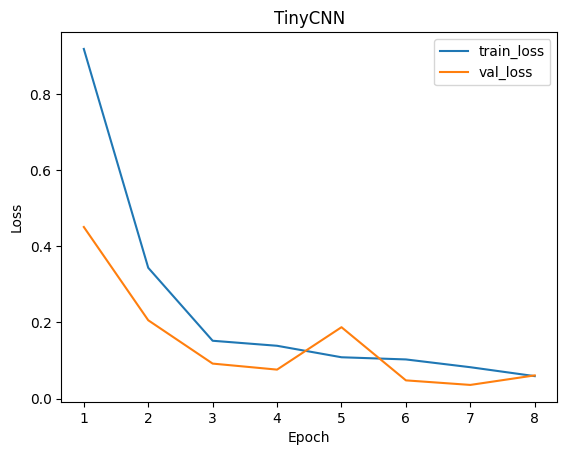

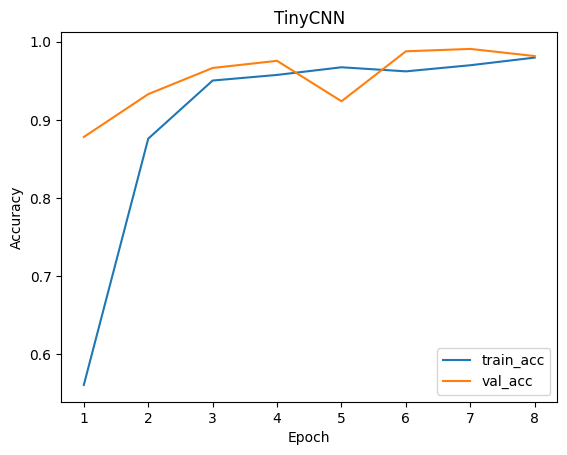

Epoch 01 | train_loss 0.9473 acc 0.732 | val_loss 0.9357 acc 0.689
Epoch 02 | train_loss 0.1086 acc 0.965 | val_loss 0.0665 acc 0.976
Epoch 03 | train_loss 0.0874 acc 0.974 | val_loss 0.8597 acc 0.750
Epoch 04 | train_loss 0.0922 acc 0.970 | val_loss 0.0581 acc 0.979
Epoch 05 | train_loss 0.0664 acc 0.985 | val_loss 0.3012 acc 0.927
Epoch 06 | train_loss 0.0572 acc 0.984 | val_loss 0.0671 acc 0.985
Epoch 07 | train_loss 0.0354 acc 0.992 | val_loss 0.0578 acc 0.988
Epoch 08 | train_loss 0.0487 acc 0.988 | val_loss 1.1187 acc 0.732
Epoch 09 | train_loss 0.0345 acc 0.988 | val_loss 0.1369 acc 0.970
Epoch 10 | train_loss 0.0651 acc 0.982 | val_loss 0.3199 acc 0.878


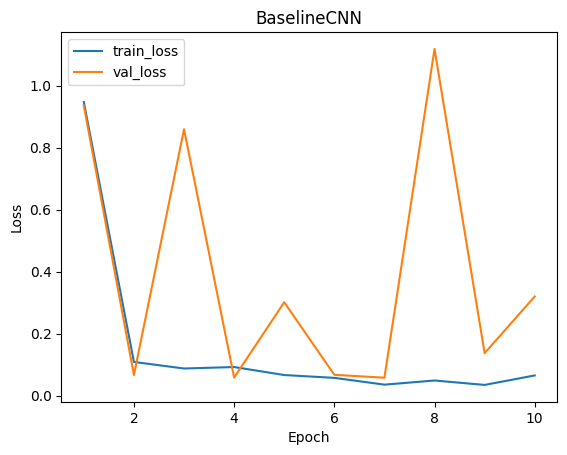

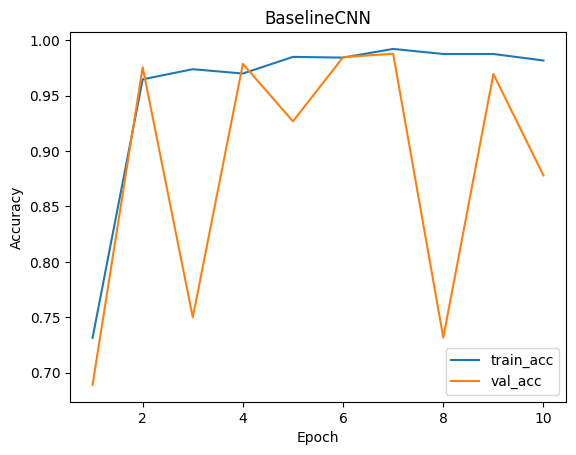

Epoch 01 | train_loss 0.3607 acc 0.891 | val_loss 0.1470 acc 0.948
Epoch 02 | train_loss 0.0968 acc 0.984 | val_loss 0.1377 acc 0.945
Epoch 03 | train_loss 0.0654 acc 0.987 | val_loss 0.0813 acc 0.979
Epoch 04 | train_loss 0.0442 acc 0.992 | val_loss 0.0657 acc 0.988
Epoch 05 | train_loss 0.0491 acc 0.988 | val_loss 0.0506 acc 0.991
Epoch 06 | train_loss 0.0292 acc 0.996 | val_loss 0.0226 acc 0.994
Epoch 07 | train_loss 0.0383 acc 0.990 | val_loss 0.0128 acc 0.997
Epoch 08 | train_loss 0.0187 acc 0.997 | val_loss 0.0197 acc 0.997
Epoch 09 | train_loss 0.0420 acc 0.988 | val_loss 0.4778 acc 0.784
Epoch 10 | train_loss 0.0324 acc 0.989 | val_loss 0.1982 acc 0.921
Epoch 11 | train_loss 0.0192 acc 0.996 | val_loss 0.0241 acc 0.994
Epoch 12 | train_loss 0.0147 acc 0.997 | val_loss 0.0171 acc 0.997


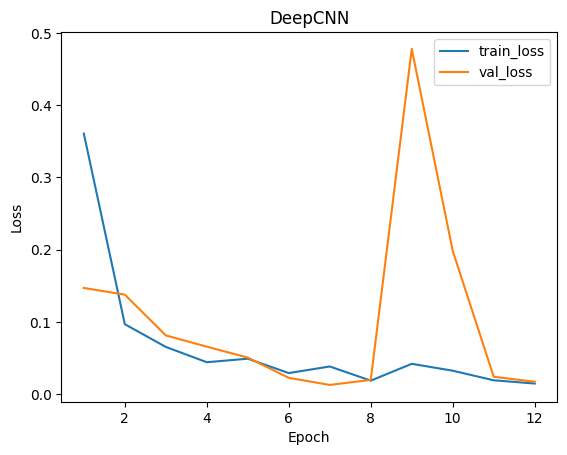

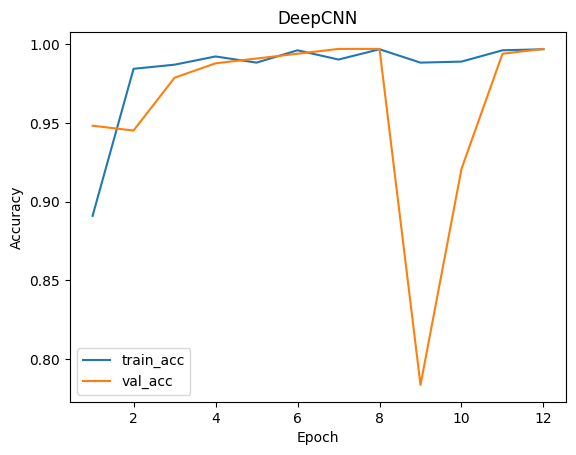

In [82]:
EPOCHS_TINY = 8
EPOCHS_BASE = 10
EPOCHS_DEEP = 12

# 1) TinyCNN
tiny = TinyCNN(NUM_CLASSES)
tiny, tiny_hist = fit(tiny, train_loader, val_loader, epochs=EPOCHS_TINY, lr=best_lr)
plot_curves(tiny_hist, "TinyCNN")

# 2) BaselineCNN (with tuned LR)
base = BaselineCNN(NUM_CLASSES)
base, base_hist = fit(base, train_loader, val_loader, epochs=EPOCHS_BASE, lr=best_lr)
plot_curves(base_hist, "BaselineCNN")

# 3) DeepCNN
deep = DeepCNN(NUM_CLASSES)
deep, deep_hist = fit(deep, train_loader, val_loader, epochs=EPOCHS_DEEP, lr=best_lr*0.5)
plot_curves(deep_hist, "DeepCNN")

In [83]:
## 11 min
# circa


=== Validation performance ===

[TinyCNN (Val)] loss=0.0359 acc=0.991
              precision    recall  f1-score   support

       paper      1.000     0.972     0.986       107
        rock      0.973     1.000     0.986       109
    scissors      1.000     1.000     1.000       112

    accuracy                          0.991       328
   macro avg      0.991     0.991     0.991       328
weighted avg      0.991     0.991     0.991       328



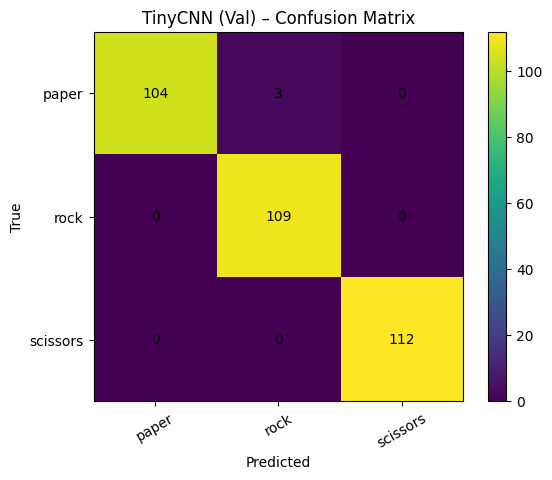


[BaselineCNN (Val)] loss=0.0578 acc=0.988
              precision    recall  f1-score   support

       paper      1.000     0.963     0.981       107
        rock      0.982     1.000     0.991       109
    scissors      0.982     1.000     0.991       112

    accuracy                          0.988       328
   macro avg      0.988     0.988     0.988       328
weighted avg      0.988     0.988     0.988       328



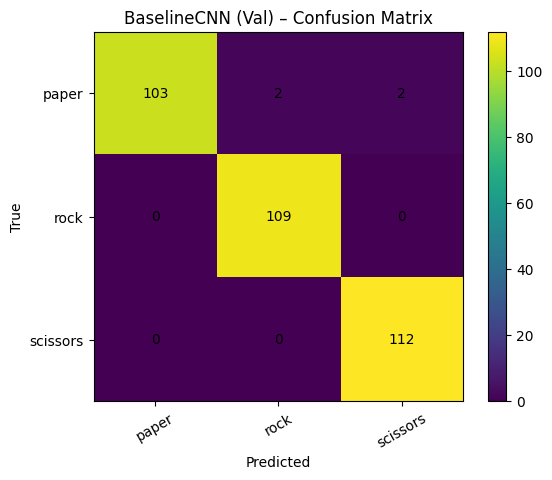


[DeepCNN (Val)] loss=0.0128 acc=0.997
              precision    recall  f1-score   support

       paper      1.000     0.991     0.995       107
        rock      1.000     1.000     1.000       109
    scissors      0.991     1.000     0.996       112

    accuracy                          0.997       328
   macro avg      0.997     0.997     0.997       328
weighted avg      0.997     0.997     0.997       328



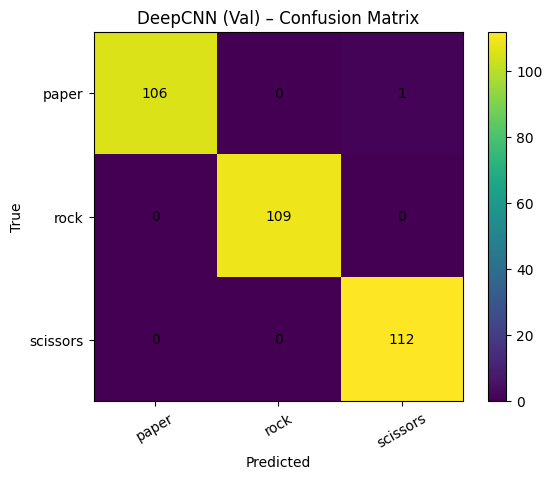

In [84]:
def eval_and_report(model, loader, title):
    criterion = nn.CrossEntropyLoss()
    loss, acc, preds, targets = evaluate(model.to(DEVICE), loader, criterion)
    print(f"\n[{title}] loss={loss:.4f} acc={acc:.3f}")
    print(classification_report(targets, preds, target_names=CLASS_NAMES, digits=3))
    cm = confusion_matrix(targets, preds)
    # Plot confusion matrix
    import numpy as np
    plt.figure()
    plt.imshow(cm)
    plt.title(f"{title} – Confusion Matrix")
    plt.xticks(range(NUM_CLASSES), CLASS_NAMES, rotation=30)
    plt.yticks(range(NUM_CLASSES), CLASS_NAMES)
    for i in range(NUM_CLASSES):
        for j in range(NUM_CLASSES):
            plt.text(j, i, cm[i,j], ha="center", va="center")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.colorbar(); plt.show()

print("\n=== Validation performance ===")
eval_and_report(tiny, val_loader, "TinyCNN (Val)")
eval_and_report(base, val_loader, "BaselineCNN (Val)")
eval_and_report(deep, val_loader, "DeepCNN (Val)")

In [ ]:
tiny

In [ ]:
base

In [ ]:
deep

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# save models to drive
torch.save(tiny.state_dict(), "/content/drive/MyDrive/RPS-data/models/tiny.pt")
torch.save(base.state_dict(), "/content/drive/MyDrive/RPS-data/models/base.pt")
torch.save(deep.state_dict(), "/content/drive/MyDrive/RPS-data/models/deep.pt")

In [ ]:
### to load the model later
tiny_loaded = TinyCNN()   # must match the exact architecture definition
tiny_loaded.load_state_dict(torch.load("/content/drive/MyDrive/RPS-data/models/tiny.pt"))
eval_and_report(tiny_loaded, val_loader, "TinyCNN LOADED (Val)")


8) Final Test Set Evaluation (Pick Best Model)

Selected best model by recent-val-acc avg: TinyCNN

[TEST] TinyCNN | loss=0.0320 acc=0.9878
              precision    recall  f1-score   support

       paper      1.000     0.963     0.981       107
        rock      0.982     1.000     0.991       109
    scissors      0.983     1.000     0.991       113

    accuracy                          0.988       329
   macro avg      0.988     0.988     0.988       329
weighted avg      0.988     0.988     0.988       329



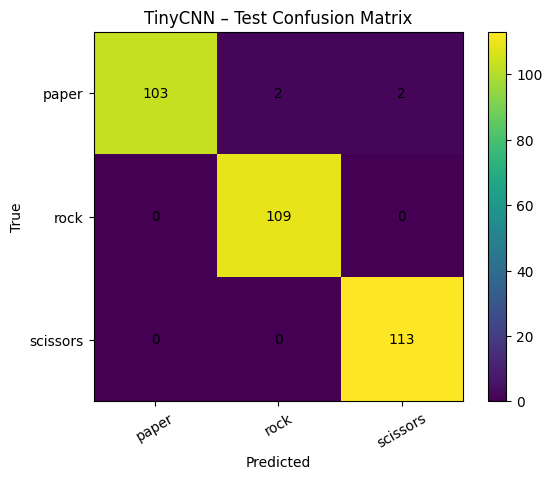

In [85]:
# Choose the model with highest val accuracy quickly:
val_scores = [
    ("TinyCNN", sum(tiny_hist["val_acc"][-3:])/3.0, tiny),
    ("BaselineCNN", sum(base_hist["val_acc"][-3:])/3.0, base),
    ("DeepCNN", sum(deep_hist["val_acc"][-3:])/3.0, deep),
]
val_scores.sort(key=lambda x: x[1], reverse=True)
best_name, _, best_model = val_scores[0]
print(f"Selected best model by recent-val-acc avg: {best_name}")

test_crit = nn.CrossEntropyLoss()
test_loss, test_acc, test_preds, test_targets = evaluate(best_model, test_loader, test_crit)
print(f"\n[TEST] {best_name} | loss={test_loss:.4f} acc={test_acc:.4f}")
print(classification_report(test_targets, test_preds, target_names=CLASS_NAMES, digits=3))

# Confusion matrix on test
cm = confusion_matrix(test_targets, test_preds)
plt.figure()
plt.imshow(cm)
plt.title(f"{best_name} – Test Confusion Matrix")
plt.xticks(range(NUM_CLASSES), CLASS_NAMES, rotation=30)
plt.yticks(range(NUM_CLASSES), CLASS_NAMES)
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.colorbar(); plt.show()


9) Misclassified Examples (Analysis)

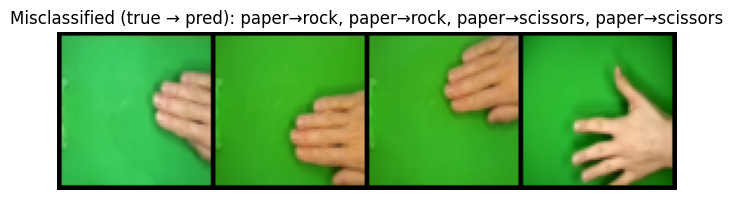

In [86]:
from torchvision.utils import make_grid

@torch.no_grad()
def collect_misclassified(model, loader, k=12):
    model.eval()
    xs, ys, ps = [], [], []
    for xb, yb in loader:
        logits = model(xb.to(DEVICE))
        pred = logits.argmax(1).cpu()
        mis = pred != yb
        for i in torch.where(mis)[0][:k - len(xs)]:
            xs.append(xb[i])
            ys.append(yb[i].item())
            ps.append(pred[i].item())
            if len(xs) >= k: break
        if len(xs) >= k: break
    if not xs: return None
    grid = make_grid(torch.stack(xs), nrow=4, padding=2, normalize=True)
    return grid, ys, ps

res = collect_misclassified(best_model, test_loader, k=12)
if res is None:
    print("No misclassifications found in sampled batch.")
else:
    grid, ys, ps = res
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1,2,0))
    plt.axis("off")
    plt.title("Misclassified (true → pred): " + ", ".join([f"{CLASS_NAMES[y]}→{CLASS_NAMES[p]}" for y,p in zip(ys,ps)]))
    plt.show()


In [2]:

from math import ceil
from pathlib import Path

# tempo medio per epoca (in secondi) misurato sul pilot
#   ~60s per 4 epoche = 15.0 s/epoca
sec_per_epoch = 15.0

# 2) conteggio immagini attuali
def count_imgs(d):
    exts = {".jpg",".jpeg",".png"}
    n=0
    for c in d.glob("*"):
        if c.is_dir():
            for p in c.glob("*"):
                if p.suffix.lower() in exts: n+=1
    return n

root = Path("data/processed")
n_tr = count_imgs(root/"train")
n_va = count_imgs(root/"val")
n_te = count_imgs(root/"test")
n_tot = n_tr + n_va

print(f"Train: {n_tr}, Val: {n_va}, Test: {n_te}, Train+Val: {n_tot}")

def epochs_total(num_combos, k, epochs):
    return num_combos * k * epochs

def print_run(name, num_combos, k, epochs, batch):
    # iterazioni per epoca dipendono dai batch, ma il tuo sec/epoca le include già.
    ep = epochs_total(num_combos, k, epochs)
    total_secs = ep * sec_per_epoch
    print(f"{name}: combos={num_combos}, k={k}, epochs={epochs} -> epoche totali={ep}, tempo≈ {total_secs/60:.1f} min")

# 3) scenari tipici (modifica a piacere)
print_run("Mini-CV arch", num_combos=3, k=3, epochs=8, batch=64)         # small/medium/large
print_run("Grid-CV ridotta", num_combos=4, k=5, epochs=10, batch=64)
print_run("Grid-CV estesa", num_combos=12, k=5, epochs=12, batch=64)
print_run("Retrain finale", num_combos=1, k=1, epochs=12, batch=64)



Train: 1531, Val: 328, Test: 329, Train+Val: 1859
Mini-CV arch: combos=3, k=3, epochs=8 -> epoche totali=72, tempo≈ 18.0 min
Grid-CV ridotta: combos=4, k=5, epochs=10 -> epoche totali=200, tempo≈ 50.0 min
Grid-CV estesa: combos=12, k=5, epochs=12 -> epoche totali=720, tempo≈ 180.0 min
Retrain finale: combos=1, k=1, epochs=12 -> epoche totali=12, tempo≈ 3.0 min
